本kernel是文章的例子，相关理论部参考知乎专栏文章https://zhuanlan.zhihu.com/p/148102950

## Table of Contents

1. [导入包](#1)
2. [导入数据](#2)
3. [EDA](#3)
4. [数据分箱](#4)
5. [特征筛选](#5)
6. [逻辑回归建模](#6)
7. [评分卡转换](#7)
8. [总结](#8)


## 导入包<a class="anchor" id="1"></a>

In [ ]:
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import math
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## 导入数据<a class="anchor" id="2"></a>

In [ ]:
df_train = pd.read_csv("/kaggle/input/GiveMeSomeCredit/cs-training.csv")
df_test = pd.read_csv("/kaggle/input/GiveMeSomeCredit/cs-test.csv")
df_train.head()

In [ ]:
df_train.info()

In [ ]:
df_train.describe()

# Exploratory Data Analysis - Preparing for one of the top performing models
本kernel EDA部分来源于 https://www.kaggle.com/nicholasgah/eda-credit-scoring-top-100-on-leaderboard


## EDA <a class="anchor" id="3"></a>

- Around 6% of samples defaulted
- MonthlyIncome and NumberOfDependents have 29731 (19.82%) and 3924 (2.61%) null values respectively
- We also notice that when NumberOfTimes90DaysLate has values above 17, there are 267 instances where the three columns NumberOfTimes90DaysLate, NumberOfTime60-89DaysPastDueNotWorse, NumberOfTime30-59DaysPastDueNotWorse share the same values, specifically 96 and 98.
    - We can see that sharing the same values of 96 and 98 respectively is not logical since trivial calculations can reveal that being 30 days past due for 96 times for a single person within a timespan of 2 years is not possible.
- RevolvingUtilizationOfUnsecuredLines
    - Defined as ratio of the total amount of money owed to total credit limit
    - distribution of values is right-skewed, consider removing outliers
    - It is expected that as this value increases, the proportion of people defaulting should increase as well
    - However, we can see that as the minimum value of this column is set to 13, the proportion of defaulters is smaller than that belonging to the pool of clients with total amount of money owed not exceeding total credit limit.
    - Thus we should remove those samples with RevolvingUtilizationOfUnsecuredLines's value more than equal to 13
- age
    - There seems to be more younger people defaulting and the distribution seems fine on the whole
- NumberOfTimes90DaysLate
    - It is interesting to note that there are no one who is 90 or more days past due between 17 and 96 times.
- NumberOfTime60-89DaysPastDueNotWorse
    - It is interesting to note that there are no one who is 60-89 days past due between 11 and 96 times.
- NumberOfTime30-59DaysPastDueNotWorse
    - It is interesting to note that there are no one who is 30-59 days past due between 13 and 96 times.
- DebtRatio
    - 2.5% of clients owe around 3490 or more times what they own
    - For the people who have monthly income in this 2.5%, only 185 people have values for their monthly incomes and the values are either 0 or 1.
    - There are 164 out of these 185 people who are of two different types, first with no monthly income and does not default and second with monthly income and does default.
- MonthlyIncome
    - Distribution of values is skewed, we can consider imputation with median.
    - We can also consider imputing with normally distributed values with its mean and standard deviation.
- Numberof Dependents
    - We can consider imputing with its mode, which is zero.

In [ ]:
sns.countplot(x="SeriousDlqin2yrs", data=df_train)
print("Default Rate: {}".format(df_train["SeriousDlqin2yrs"].sum() / len(df_train)))

### Null Values and Proportions

In [ ]:
null_val_sums = df_train.isnull().sum()
pd.DataFrame({"Column": null_val_sums.index, "Number of Null Values": null_val_sums.values,
             "Proportion": null_val_sums.values / len(df_train) })

### RevolvingUtilizationOfUnsecuredLines

In [ ]:
df_train["RevolvingUtilizationOfUnsecuredLines"].describe()

In [ ]:
sns.distplot(df_train["RevolvingUtilizationOfUnsecuredLines"])

In [ ]:
default_prop = []
for i in range(int(df_train["RevolvingUtilizationOfUnsecuredLines"].max())):
    temp_ = df_train.loc[df_train["RevolvingUtilizationOfUnsecuredLines"] >= i]
    default_prop.append([i, temp_["SeriousDlqin2yrs"].mean()])
default_prop

In [ ]:
sns.lineplot(x=[i[0] for i in default_prop], y=[i[1] for i in default_prop])
plt.title("Proportion of Defaulters As Minimum RUUL Increases")

In [ ]:
print("Proportion of Defaulters with Total Amount of Money Owed Not Exceeding Total Credit Limit: {}"\
     .format(df_train.loc[(df_train["RevolvingUtilizationOfUnsecuredLines"] >= 0) & (df_train["RevolvingUtilizationOfUnsecuredLines"] <= 1)]["SeriousDlqin2yrs"].mean()))

In [ ]:
print("Proportion of Defaulters with Total Amount of Money Owed Not Exceeding or Equal to 13 times of Total Credit Limit:\n{}"\
     .format(df_train.loc[(df_train["RevolvingUtilizationOfUnsecuredLines"] >= 0) & (df_train["RevolvingUtilizationOfUnsecuredLines"] < 13)]["SeriousDlqin2yrs"].mean()))

### age

In [ ]:
df_train["age"].describe()

In [ ]:
sns.distplot(df_train["age"])

In [ ]:
sns.distplot(df_train.loc[df_train["SeriousDlqin2yrs"] == 0]["age"])

In [ ]:
sns.distplot(df_train.loc[df_train["SeriousDlqin2yrs"] == 1]["age"])

### Late Payment Columns

- NumberOfTimes90DaysLate
- NumberOfTime60-89DaysPastDueNotWorse
- NumberOfTime30-59DaysPastDueNotWorse

In [ ]:
late_pay_cols = ["NumberOfTimes90DaysLate", "NumberOfTime60-89DaysPastDueNotWorse",
                "NumberOfTime30-59DaysPastDueNotWorse"]
df_train["NumberOfTimes90DaysLate"].value_counts().sort_index()

In [ ]:
df_train["NumberOfTime60-89DaysPastDueNotWorse"].value_counts().sort_index()

In [ ]:
df_train["NumberOfTime30-59DaysPastDueNotWorse"].value_counts().sort_index()

In [ ]:
df_train.loc[df_train["NumberOfTimes90DaysLate"] > 17][late_pay_cols].describe()

In [ ]:
distinct_triples_counts = dict()
for arr in df_train.loc[df_train["NumberOfTimes90DaysLate"] > 17][late_pay_cols].values:
    triple = ",".join(list(map(str, arr)))
    if triple not in distinct_triples_counts:
        distinct_triples_counts[triple] = 0
    else:
        distinct_triples_counts[triple] += 1
distinct_triples_counts

### DebtRatio

In [ ]:
df_train["DebtRatio"].describe()

In [ ]:
df_train["DebtRatio"].quantile(0.95)

In [ ]:
df_train.loc[df_train["DebtRatio"] > df_train["DebtRatio"].quantile(0.95)][["DebtRatio", "MonthlyIncome", "SeriousDlqin2yrs"]].describe()

In [ ]:
len(df_train[(df_train["DebtRatio"] > df_train["DebtRatio"].quantile(0.95)) & (df_train['SeriousDlqin2yrs'] == df_train['MonthlyIncome'])])

In [ ]:
df_train.loc[df_train["DebtRatio"] > df_train["DebtRatio"].quantile(0.95)]["MonthlyIncome"].value_counts()

In [ ]:
print("Number of people who owe around 2449 or more times what they own and have same values for MonthlyIncome and SeriousDlqin2yrs: {}"\
     .format(len(df_train.loc[(df_train["DebtRatio"] > df_train["DebtRatio"].quantile(0.95)) & (df_train["MonthlyIncome"] == df_train["SeriousDlqin2yrs"])])))

In [ ]:
df_train["DebtRatio"].quantile(0.975)

In [ ]:
df_train.loc[df_train["DebtRatio"] > df_train["DebtRatio"].quantile(0.975)][["DebtRatio", "MonthlyIncome", "SeriousDlqin2yrs"]].describe()

In [ ]:
len(df_train[(df_train["DebtRatio"] > df_train["DebtRatio"].quantile(0.975)) & (df_train['SeriousDlqin2yrs'] == df_train['MonthlyIncome'])])

In [ ]:
df_train.loc[df_train["DebtRatio"] > df_train["DebtRatio"].quantile(0.975)]["MonthlyIncome"].value_counts()

In [ ]:
print("Number of people who owe around 3490 or more times what they own and have same values for MonthlyIncome and SeriousDlqin2yrs: {}"\
     .format(len(df_train.loc[(df_train["DebtRatio"] > df_train["DebtRatio"].quantile(0.975)) & (df_train["MonthlyIncome"] == df_train["SeriousDlqin2yrs"])])))

### MonthlyIncome

In [ ]:
sns.distplot(df_train["MonthlyIncome"].dropna())

In [ ]:
df_train["MonthlyIncome"].describe()

In [ ]:
sns.distplot(df_train.loc[df_train["DebtRatio"] <= df_train["DebtRatio"].quantile(0.975)]["MonthlyIncome"].dropna())

### NumberOfOpenCreditLinesAndLoans

In [ ]:
df_train["NumberOfOpenCreditLinesAndLoans"].describe()

In [ ]:
sns.distplot(df_train["NumberOfOpenCreditLinesAndLoans"])

### NumberRealEstateLoansOrLines

In [ ]:
df_train["NumberRealEstateLoansOrLines"].describe()

In [ ]:
sns.countplot(x="NumberRealEstateLoansOrLines", data=df_train.loc[df_train["NumberRealEstateLoansOrLines"] <= 10])

In [ ]:
df_train.loc[df_train["NumberRealEstateLoansOrLines"] > 13]["SeriousDlqin2yrs"].describe()

### NumberOfDependents

In [ ]:
df_train["NumberOfDependents"].describe()

In [ ]:
df_train["NumberOfDependents"].value_counts()

In [ ]:
df_train.loc[df_train["NumberOfDependents"] <= 10]["SeriousDlqin2yrs"].describe()

In [ ]:
sns.countplot(x="NumberOfDependents", data=df_train.loc[df_train["NumberOfDependents"] <= 10])

## 数据分箱 <a class="anchor" id="4"></a>

In [ ]:
df_train = df_train.fillna(df_train.median())
print(df_train.isnull().sum())

需要 qcut的:
* RevolvingUtilizationOfUnsecuredLines
* DebtRatio
* MonthlyIncome
* NumberOfOpenCreditLinesAndLoans
* NumberRealEstateLoansOrLines
	

需要 cut的:
* age
* NumberOfDependents
* NumberOfTime30-59DaysPastDueNotWorse
* NumberOfTimes90DaysLate
* NumberOfTime60-89DaysPastDueNotWorse


In [ ]:

age_bins = [-math.inf, 25, 40, 50, 60, 70, math.inf]
df_train['bin_age'] = pd.cut(df_train['age'],bins=age_bins).astype(str)
dependent_bin = [-math.inf,2,4,6,8,10,math.inf]
df_train['bin_NumberOfDependents'] = pd.cut(df_train['NumberOfDependents'],bins=dependent_bin).astype(str)
dpd_bins = [-math.inf,1,2,3,4,5,6,7,8,9,math.inf]
df_train['bin_NumberOfTimes90DaysLate'] = pd.cut(df_train['NumberOfTimes90DaysLate'],bins=dpd_bins)
df_train['bin_NumberOfTime30-59DaysPastDueNotWorse'] = pd.cut(df_train['NumberOfTime30-59DaysPastDueNotWorse'], bins=dpd_bins)
df_train['bin_NumberOfTime60-89DaysPastDueNotWorse'] = pd.cut(df_train['NumberOfTime60-89DaysPastDueNotWorse'], bins=dpd_bins)


df_train['bin_RevolvingUtilizationOfUnsecuredLines'] = pd.qcut(df_train['RevolvingUtilizationOfUnsecuredLines'],q=5,duplicates='drop').astype(str)
df_train['bin_DebtRatio'] = pd.qcut(df_train['DebtRatio'],q=5,duplicates='drop').astype(str)
df_train['bin_MonthlyIncome'] = pd.qcut(df_train['MonthlyIncome'],q=5,duplicates='drop').astype(str)
df_train['bin_NumberOfOpenCreditLinesAndLoans'] = pd.qcut(df_train['NumberOfOpenCreditLinesAndLoans'],q=5,duplicates='drop').astype(str)
df_train['bin_NumberRealEstateLoansOrLines'] = pd.qcut(df_train['NumberRealEstateLoansOrLines'],q=5,duplicates='drop').astype(str)


In [ ]:
bin_cols = [c for c in df_train.columns.values if c.startswith('bin_')]


## 特征筛选 <a class="anchor" id="5"></a>

In [ ]:
def cal_IV(df, feature, target):
    lst = []
    cols=['Variable', 'Value', 'All', 'Bad']
    for i in range(df[feature].nunique()):
        
        val = list(df[feature].unique())[i]
        lst.append([feature, val, df[df[feature] == val].count()[feature], df[(df[feature] == val) & (df[target] == 1)].count()[feature]])
#     print(lst)
    data = pd.DataFrame(lst, columns=cols)
    data = data[data['Bad'] > 0]

    data['Share'] = data['All'] / data['All'].sum()
    data['Bad Rate'] = data['Bad'] / data['All']
    data['Distribution Good'] = (data['All'] - data['Bad']) / (data['All'].sum() - data['Bad'].sum())
    data['Distribution Bad'] = data['Bad'] / data['Bad'].sum()
    data['WoE'] = np.log(data['Distribution Bad'] / data['Distribution Good'])
    data['IV'] = (data['WoE'] * (data['Distribution Bad'] - data['Distribution Good'])).sum()

    data = data.sort_values(by=['Variable', 'Value'], ascending=True)

    return data['IV'].values[0]

In [ ]:
for f in bin_cols:
    print(f)
    print(cal_IV(df_train,f,'SeriousDlqin2yrs'))

只选择IV>0.1的，入选的有五个变量：
* bin_RevolvingUtilizationOfUnsecuredLines
* bin_NumberOfTime30-59DaysPastDueNotWorse	
* bin_age
* bin_NumberOfTimes90DaysLate
* bin_NumberOfTime60-89DaysPastDueNotWorse	


In [ ]:
def cal_WOE(df,features,target):
    df_new = df
    for f in features:
        df_woe = df_new.groupby(f).agg({target:['sum','count']})
        df_woe.columns = list(map(''.join, df_woe.columns.values))
        df_woe = df_woe.reset_index()
        df_woe = df_woe.rename(columns = {target+'sum':'bad'})
        df_woe = df_woe.rename(columns = {target+'count':'all'})
        df_woe['good'] = df_woe['all']-df_woe['bad']
        df_woe = df_woe[[f,'good','bad']]
        df_woe['bad_rate'] = df_woe['bad'].mask(df_woe['bad']==0, 1)/df_woe['bad'].sum() # mask 0 to 1 to avoid log(0)
        df_woe['good_rate'] = df_woe['good']/df_woe['good'].sum()
        
        df_woe['woe'] = np.log(df_woe['bad_rate'].divide(df_woe['good_rate'],fill_value=1))
        df_woe.columns = [c if c==f else c+'_'+f for c in list(df_woe.columns.values)]
        df_new = df_new.merge(df_woe,on=f,how='left')
    return df_new
        

    

In [ ]:
# 我们根据IV选出来的特征
feature_cols = ['RevolvingUtilizationOfUnsecuredLines','NumberOfTime30-59DaysPastDueNotWorse','age','NumberOfTimes90DaysLate','NumberOfTime60-89DaysPastDueNotWorse']
bin_cols = ['bin_RevolvingUtilizationOfUnsecuredLines','bin_NumberOfTime30-59DaysPastDueNotWorse','bin_age','bin_NumberOfTimes90DaysLate','bin_NumberOfTime60-89DaysPastDueNotWorse']
df_woe = cal_WOE(df_train,bin_cols,'SeriousDlqin2yrs')
woe_cols = [c for c in list(df_woe.columns.values) if 'woe' in c]
df_woe[woe_cols]


In [ ]:
# df2 = df_woe[['woe_bin_age','bin_age']].drop_duplicates()
# df2.head(10)

In [ ]:
df_bin_to_woe = pd.DataFrame(columns = ['features','bin','woe'])
for f in feature_cols:
    b = 'bin_'+f
    w = 'woe_bin_'+f
    df = df_woe[[w,b]].drop_duplicates()
    df.columns = ['woe','bin']
    df['features'] = f
    df=df[['features','bin','woe']]
    df_bin_to_woe = pd.concat([df_bin_to_woe,df])
df_bin_to_woe

## 逻辑回归建模 <a class="anchor" id="6"></a>

留30%作为模型的验证集

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_woe[woe_cols], df_woe['SeriousDlqin2yrs'], test_size=0.2, random_state=42)

In [ ]:
print('bad rate is: ',y_train.mean())

In [ ]:
#尝试过SMOTE去过采样，但没啥效果，就注释掉了
# from imblearn.over_sampling import SMOTE 
# sm = SMOTE(random_state=42)
# X_train, y_train = sm.fit_resample(X_train, y_train)
# print('bad rate is: ',y_train.mean())

In [ ]:
X_train.describe()

In [ ]:
model = LogisticRegression(random_state=42).fit(X_train,y_train)

In [ ]:
#在验证集上看性能
model.score(X_test,y_test)

因为比赛是用AUC作为标准，所以我也看看我的模型AUC多少

In [ ]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = model.predict_proba(X_test)

preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
#混淆矩阵
y_pred = model.predict(X_test)
metrics.confusion_matrix(y_test,y_pred)

In [ ]:
model.coef_

## 评分卡转换 <a class="anchor" id="7"></a>

### 需要计算A和B的话，我们设置两个参数
1. 基准分。我们设θ_0为20：1时的多数风控策略基准分都设置为650，我们就试试650吧，基准分为A-B\theta_0
2. PDO（point of double），比率翻番时分数的变动值。假设我们设置为当odds翻倍时，分值减少30。

而A、B计算公式（推导过程详见我的知乎专栏 https://zhuanlan.zhihu.com/p/148102950）

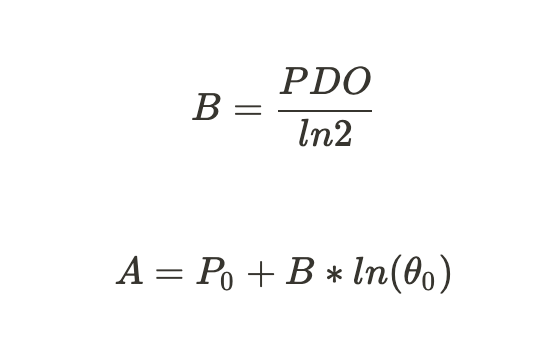



代入数字可算得
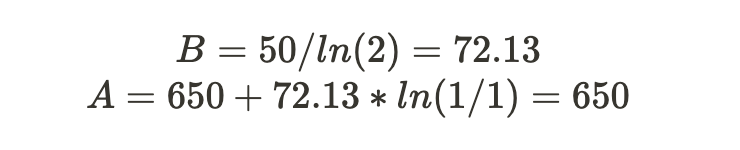

In [ ]:
A = 650
B =72.13

In [ ]:
def generate_scorecard(model_coef,binning_df,features,B):
    lst = []
    cols = ['Variable','Binning','Score']
    coef = model_coef[0]
    for i in range(len(features)):
        f = features[i]
        df = binning_df[binning_df['features']==f]
        for index,row in df.iterrows():
            lst.append([f,row['bin'],int(round(-coef[i]*row['woe']*B))])
    data = pd.DataFrame(lst, columns=cols)
    return data
    

In [ ]:
score_card = generate_scorecard(model.coef_,df_bin_to_woe,feature_cols,B)
score_card
    

可以看到基本每项都是减分项。为了方便查看，这里再分组排序下，每组按照分值的高低

In [ ]:
sort_scorecard = score_card.groupby('Variable').apply(lambda x: x.sort_values('Score', ascending=False))
sort_scorecard

可以看到，总体来说评分符合预期，例如RevolvingUtilizationOfUnsecuredLines越高，给的分数越低。
不过也有的评分并不是完全符合预期，例如NumberOfTime60-89DaysPastDueNotWorse在(8.0, 9.0]段的分数竟然是0，这完全没道理啊！这个问题的出现，和训练集在这个分数段的样本量有关，解决方法可以是重新设计分箱策略，不过本kernel的目的是做个baseline，读者有兴趣可以研究下如何优化

为了验证评分卡的效果，我们选两个0，两个1。别想歪了，我说的是SeriousDlqin2yrs == 0 或者 SeriousDlqin2yrs == 1,为了notebook重新运行时结果不变，我固定一个random state。

In [ ]:
# 本段代码的目的是把输入数据映射到分箱，并且选取相应的分值来计算最后的信用评分
def str_to_int(s):
    if s == '-inf':
        return -999999999.0
    elif s=='inf':
        return 999999999.0
    else:
        return float(s)
    
def map_value_to_bin(feature_value,feature_to_bin):
    for idx, row in feature_to_bin.iterrows():
        bins = str(row['Binning'])
        left_open = bins[0]=="("
        right_open = bins[-1]==")"
        binnings = bins[1:-1].split(',')
        in_range = True
        # check left bound
        if left_open:
            if feature_value<= str_to_int(binnings[0]):
                in_range = False   
        else:
            if feature_value< str_to_int(binnings[0]):
                in_range = False   
        #check right bound
        if right_open:
            if feature_value>= str_to_int(binnings[1]):
                in_range = False 
        else:
            if feature_value> str_to_int(binnings[1]):
                in_range = False   
        if in_range:
            return row['Binning']
    return null

def map_to_score(df,score_card):
    scored_columns = list(score_card['Variable'].unique())
    score = 0
    for col in scored_columns:
        feature_to_bin = score_card[score_card['Variable']==col]
        feature_value = df[col]
        selected_bin = map_value_to_bin(feature_value,feature_to_bin)
        selected_record_in_scorecard = feature_to_bin[feature_to_bin['Binning'] == selected_bin]
        score += selected_record_in_scorecard['Score'].iloc[0]
    return score  

def calculate_score_with_card(df,score_card,A):
    df['score'] = df.apply(map_to_score,args=(score_card,),axis=1)
    df['score'] = df['score']+A
    df['score'] = df['score'].astype(int)
    return df
        
        

    

In [ ]:
good_sample = df_train[df_train['SeriousDlqin2yrs']==0].sample(5, random_state=1)
good_sample = good_sample[feature_cols]
bad_sample = df_train[df_train['SeriousDlqin2yrs']==1].sample(5, random_state=1)
bad_sample = bad_sample[feature_cols]


In [ ]:
calculate_score_with_card(good_sample,score_card,A)

In [ ]:
calculate_score_with_card(bad_sample,score_card,A)

可以看到，好的样本分数评分都比坏样本分数低，说明了评分卡的有效性。例如上面的例子，好的样本分数都是500以上，坏的样本都在500以下。虽然换些样本会发现未必完成准确，但总体来说能识别较多的坏客户。

## 总结 <a class="anchor" id="8"></a>
本kernel设计了一个baseline的评分卡，采用了简单的分箱策略，计算了每个分箱的woe值，最后转换成评分卡。本kernel仍有很多优化空间，欢迎读者fork并且尝试进行优化